In [2]:
import stim

In [3]:
def gen_circuit(d, logical=False, x_mem=False):
    distance = d
    # 1) generate the memory circuit
    if x_mem:
        memory = stim.Circuit.generated(
            "surface_code:rotated_memory_x",
            rounds=1,   # whatever you actually want for runtime rounds
            distance=distance
        )

    else:
        memory = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=1,   # whatever you actually want for runtime rounds
            distance=distance
        )

    if logical:
        # the physical qubits forming the logical-X chain you picked
        logical_x_chain = range(1, distance*2, 2)

        # 2) text form of the circuit and split to lines
        text = str(memory)
        lines = text.splitlines()

        # 3) find the first contiguous block of R lines
        r_start = None
        r_end = None
        n = len(lines)
        i = 0

        # skip any leading blank/comment lines until the first op
        while i < n and lines[i].strip() == "":
            i += 1

        # find first R line
        while i < n:
            if lines[i].strip().startswith("R"):
                r_start = i
                break
            # if the first op isn't R, keep searching (rare for these generated circuits)
            i += 1

        # if found, walk forward until the R-block ends
        if r_start is not None:
            j = r_start
            while j < n and lines[j].strip().startswith("R"):
                j += 1
            r_end = j - 1  # index of last R in the first contiguous block

        # safety: ensure we found a reset block
        if r_start is None or r_end is None:
            raise RuntimeError("Couldn't find the initial reset ('R') block in the generated circuit.")

        # 4) prepare X instruction lines (one X per qubit)
        x_lines = [f"X {q}" for q in logical_x_chain]

        # 5) insert Xs immediately after the first reset block only
        new_lines = lines[: r_end + 1] + x_lines + lines[r_end + 1 :]
        new_text = "\n".join(new_lines) + "\n"

        # 6) parse back into a stim.Circuit
        return stim.Circuit(new_text)
    
    else:
        return memory

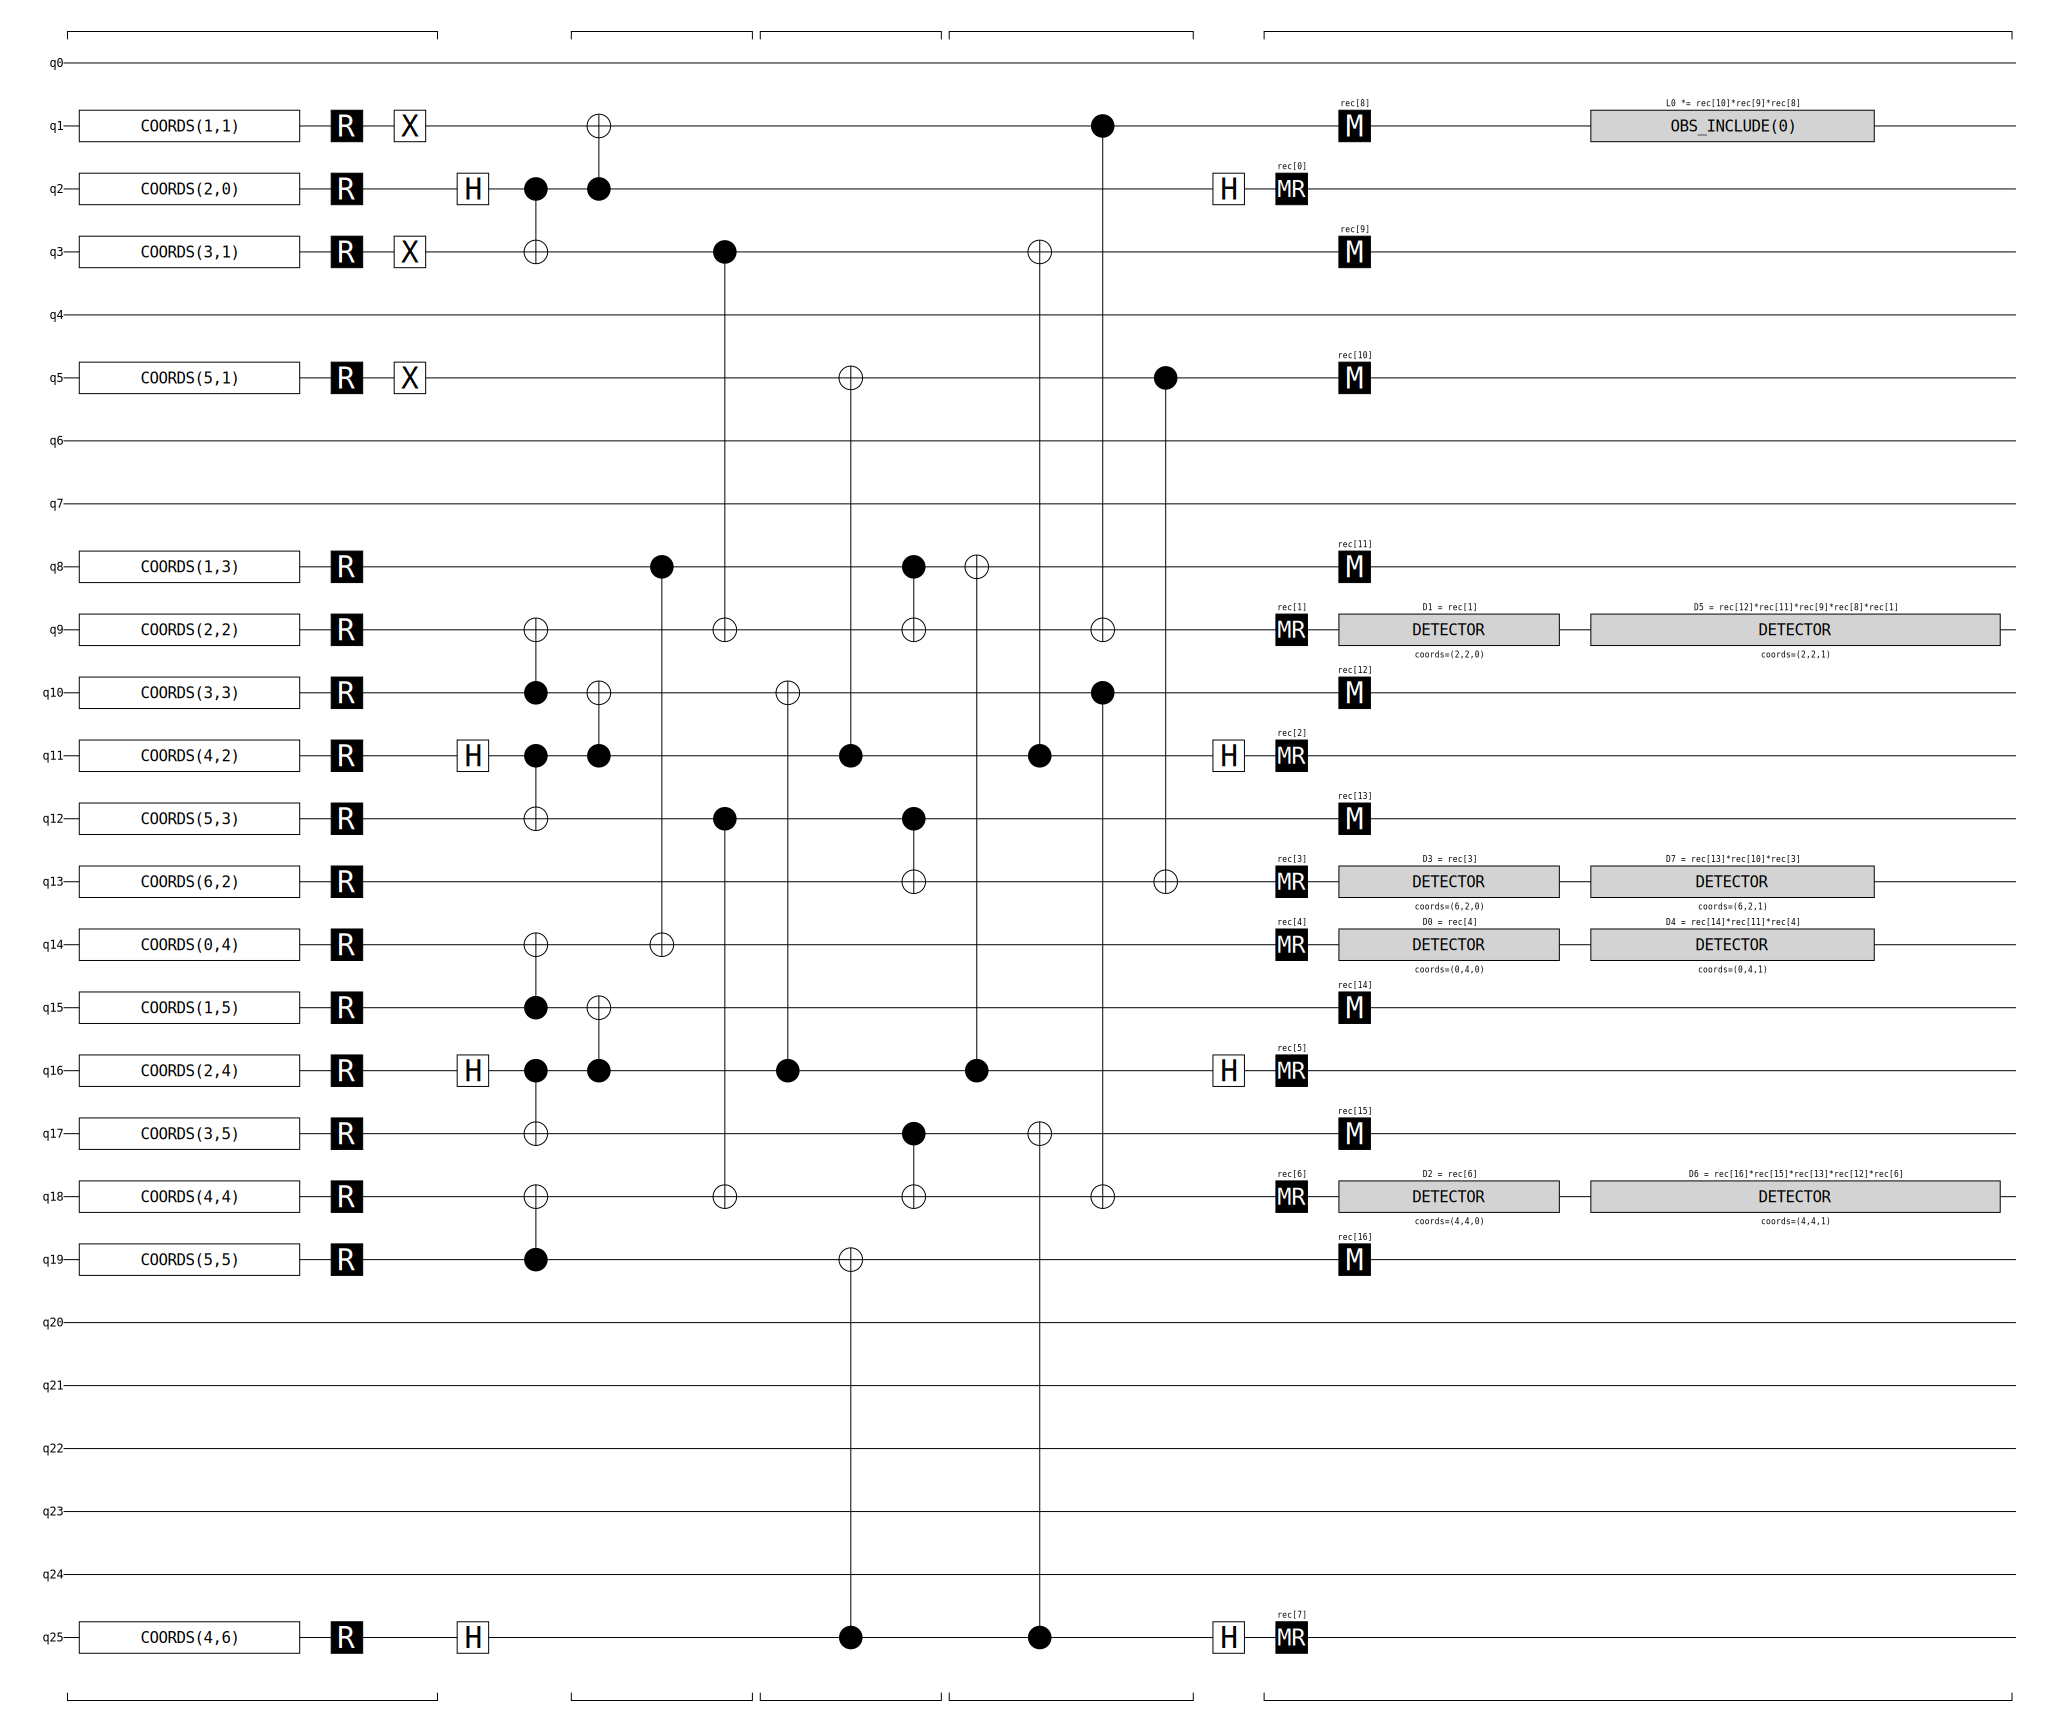

In [4]:
stim_circuit = gen_circuit(3, True)
stim_circuit.diagram('timeline-svg')

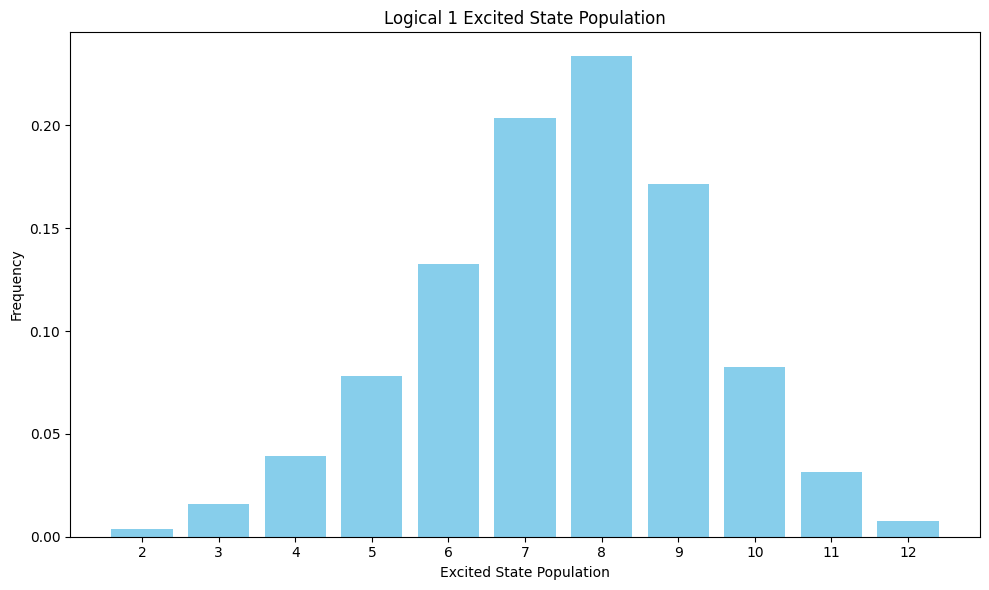

In [5]:
stim_sampler = stim_circuit.compile_sampler()
num_shots = 1000000
stim_samples = stim_sampler.sample(num_shots)

import matplotlib.pyplot as plt

import numpy as np
from collections import Counter

# For each sample, count the number of excited states (1s).
excited_state_counts = [np.sum(row) for row in stim_samples]

# Count the occurrences of each excited state population count.
population_counts = Counter(excited_state_counts)

# Prepare data for plotting, ensuring it's sorted by the population count.
labels, counts = zip(*sorted(population_counts.items()))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels,  np.array(counts)/num_shots, color='skyblue')
plt.xlabel("Excited State Population")
plt.ylabel("Frequency")
plt.title(f"Logical 1 Excited State Population")
plt.xticks(labels) # Ensure all population counts are shown as ticks
plt.tight_layout()
plt.show()


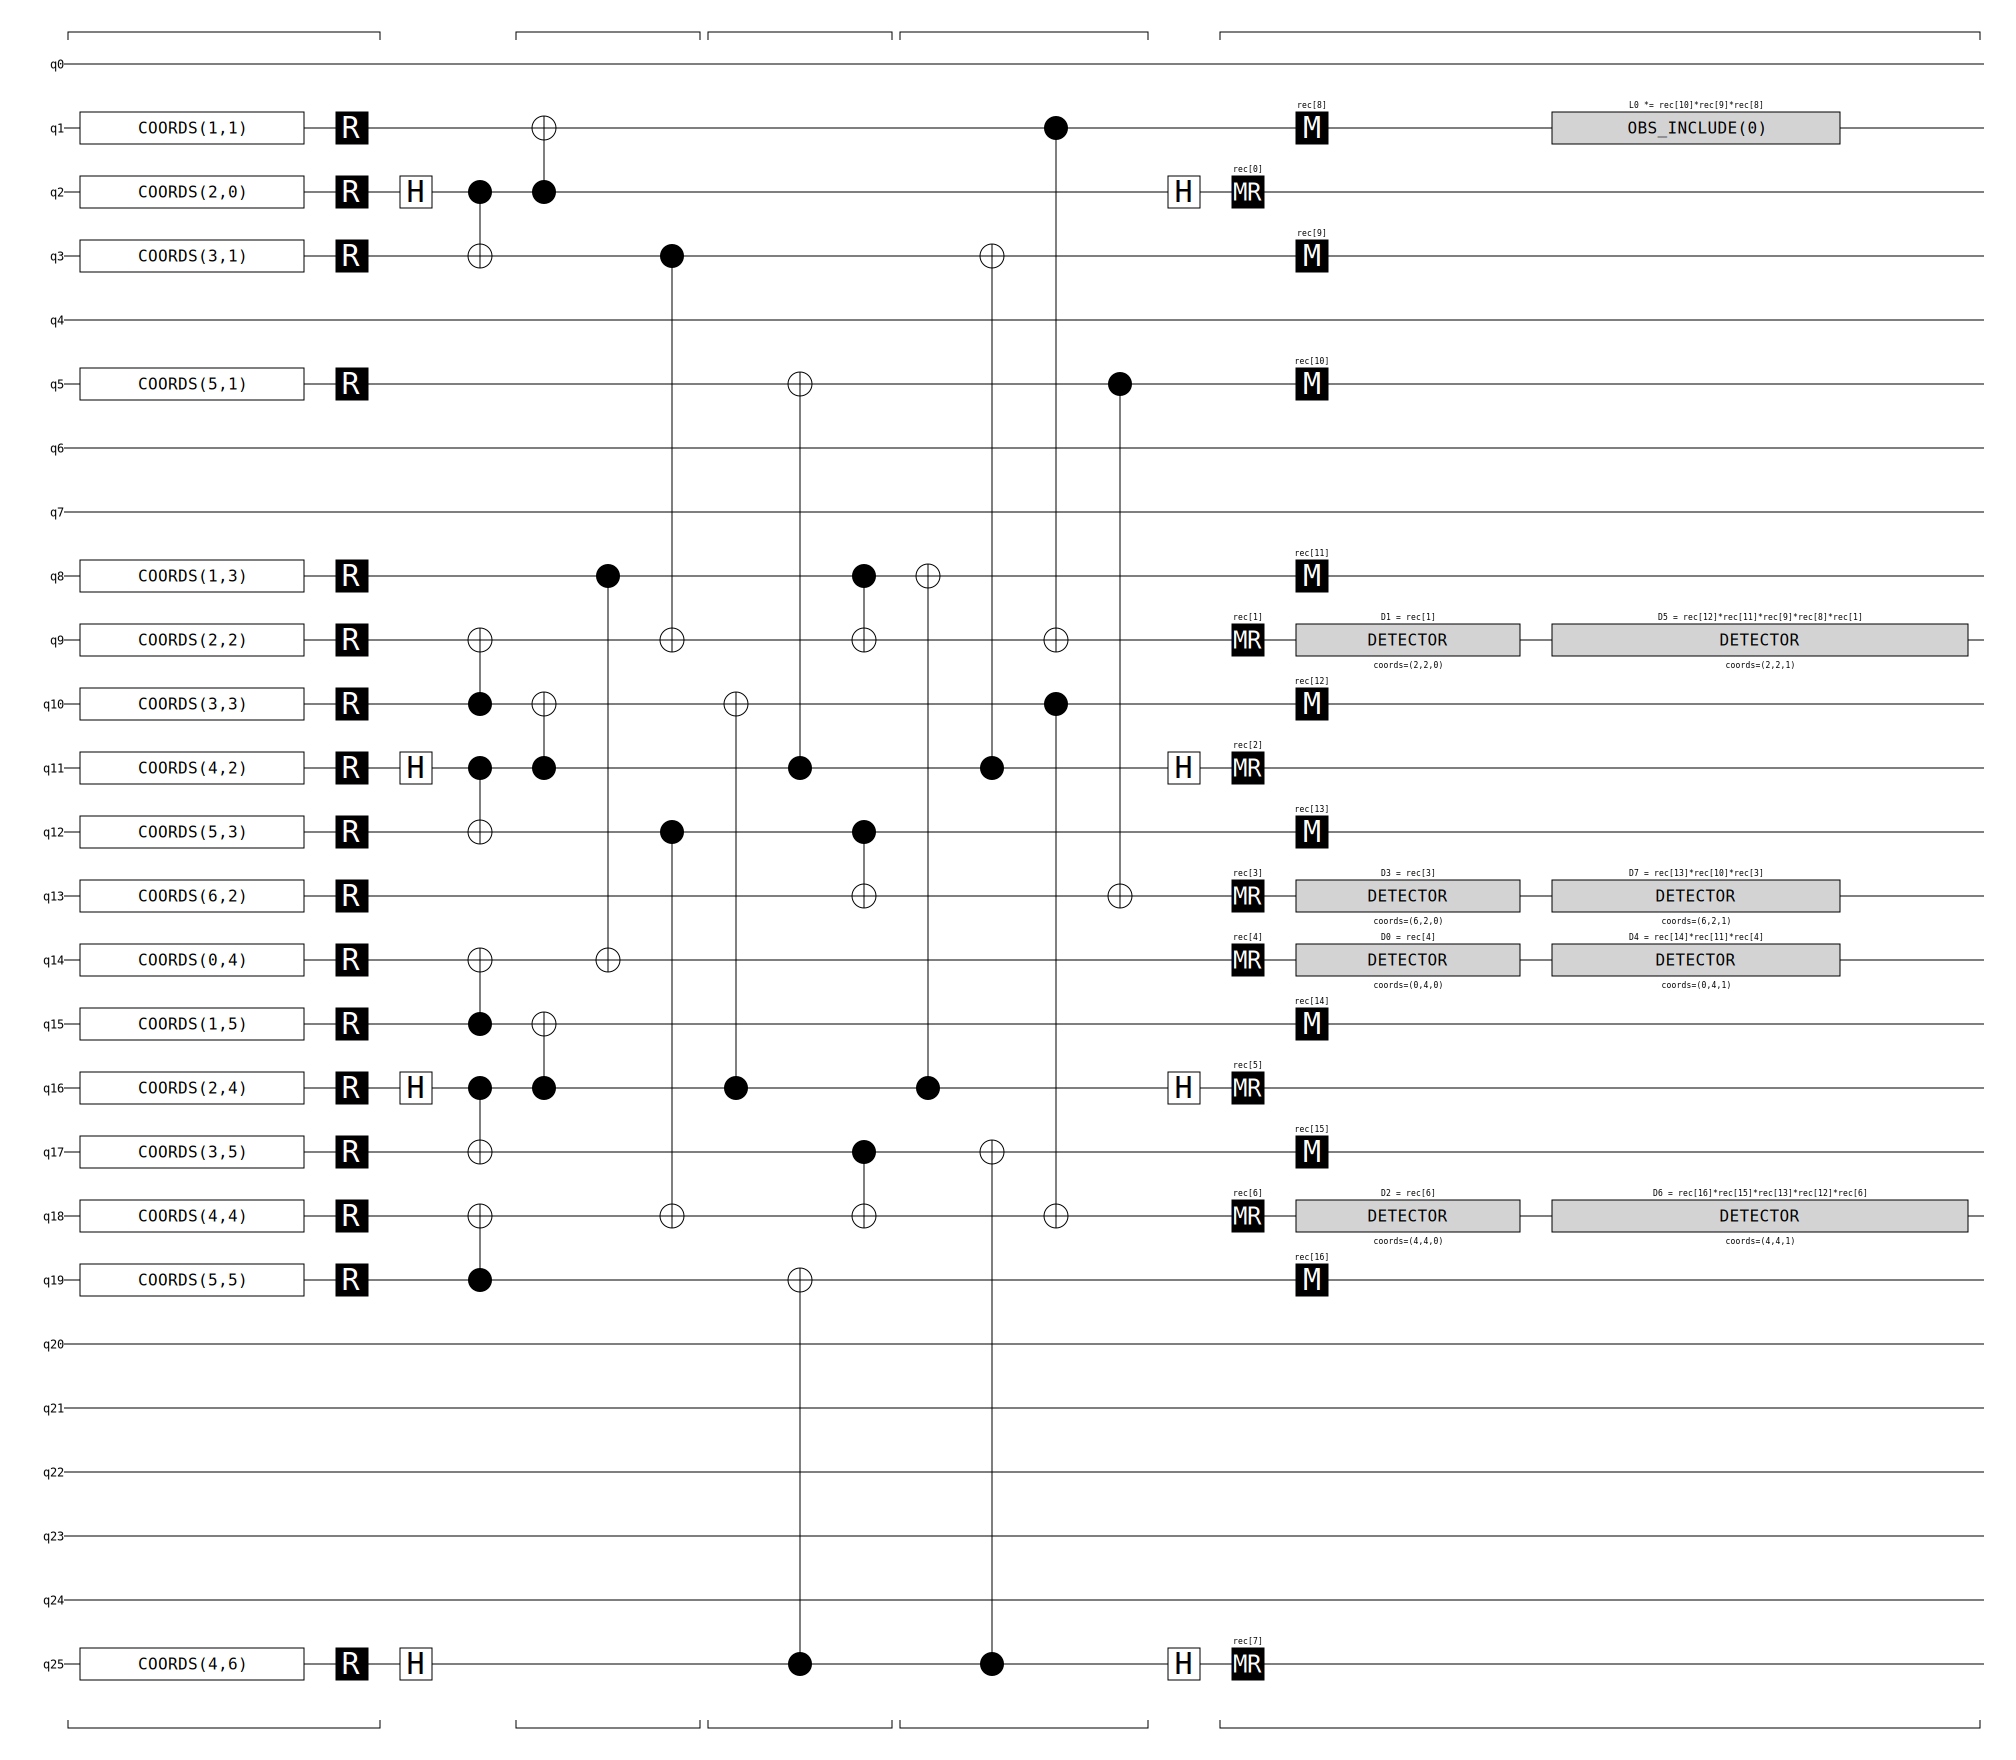

In [6]:
stim_circuit = gen_circuit(3)
stim_circuit.diagram('timeline-svg')

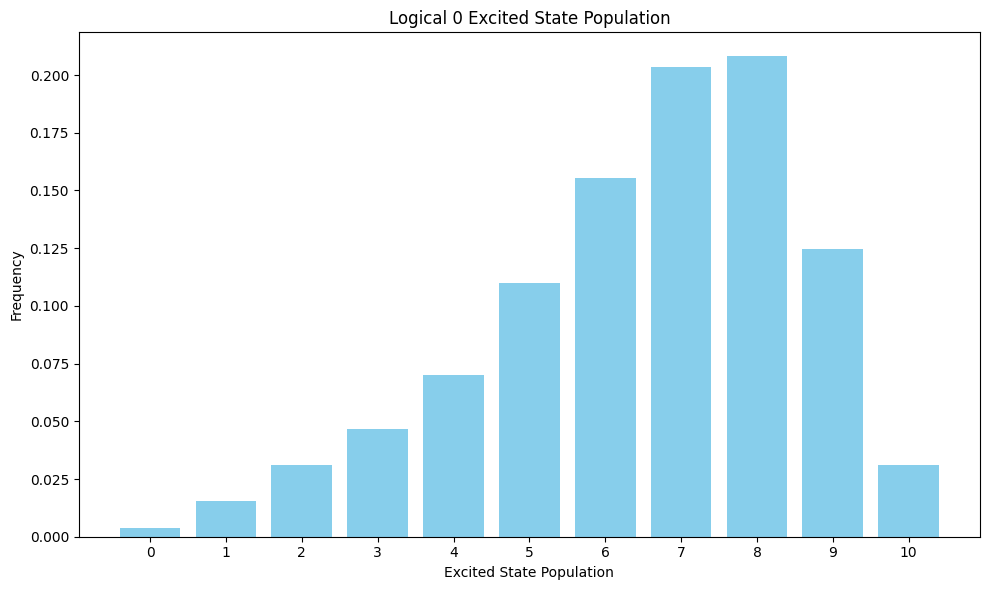

In [7]:

stim_sampler = stim_circuit.compile_sampler()
num_shots = 1000000
stim_samples = stim_sampler.sample(num_shots)

import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from collections import Counter

# For each sample, count the number of excited states (1s).
excited_state_counts = [np.sum(row) for row in stim_samples]

# Count the occurrences of each excited state population count.
population_counts = Counter(excited_state_counts)

# Prepare data for plotting, ensuring it's sorted by the population count.
labels, counts = zip(*sorted(population_counts.items()))


# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, np.array(counts)/num_shots, color='skyblue')
plt.xlabel("Excited State Population")
plt.ylabel("Frequency")
plt.title(f"Logical 0 Excited State Population")
plt.xticks(labels) # Ensure all population counts are shown as ticks
plt.tight_layout()
plt.show()


In [8]:
print(np.var(np.array(counts)))

print(np.mean(np.array(counts)))

4987738658.082644
90909.09090909091


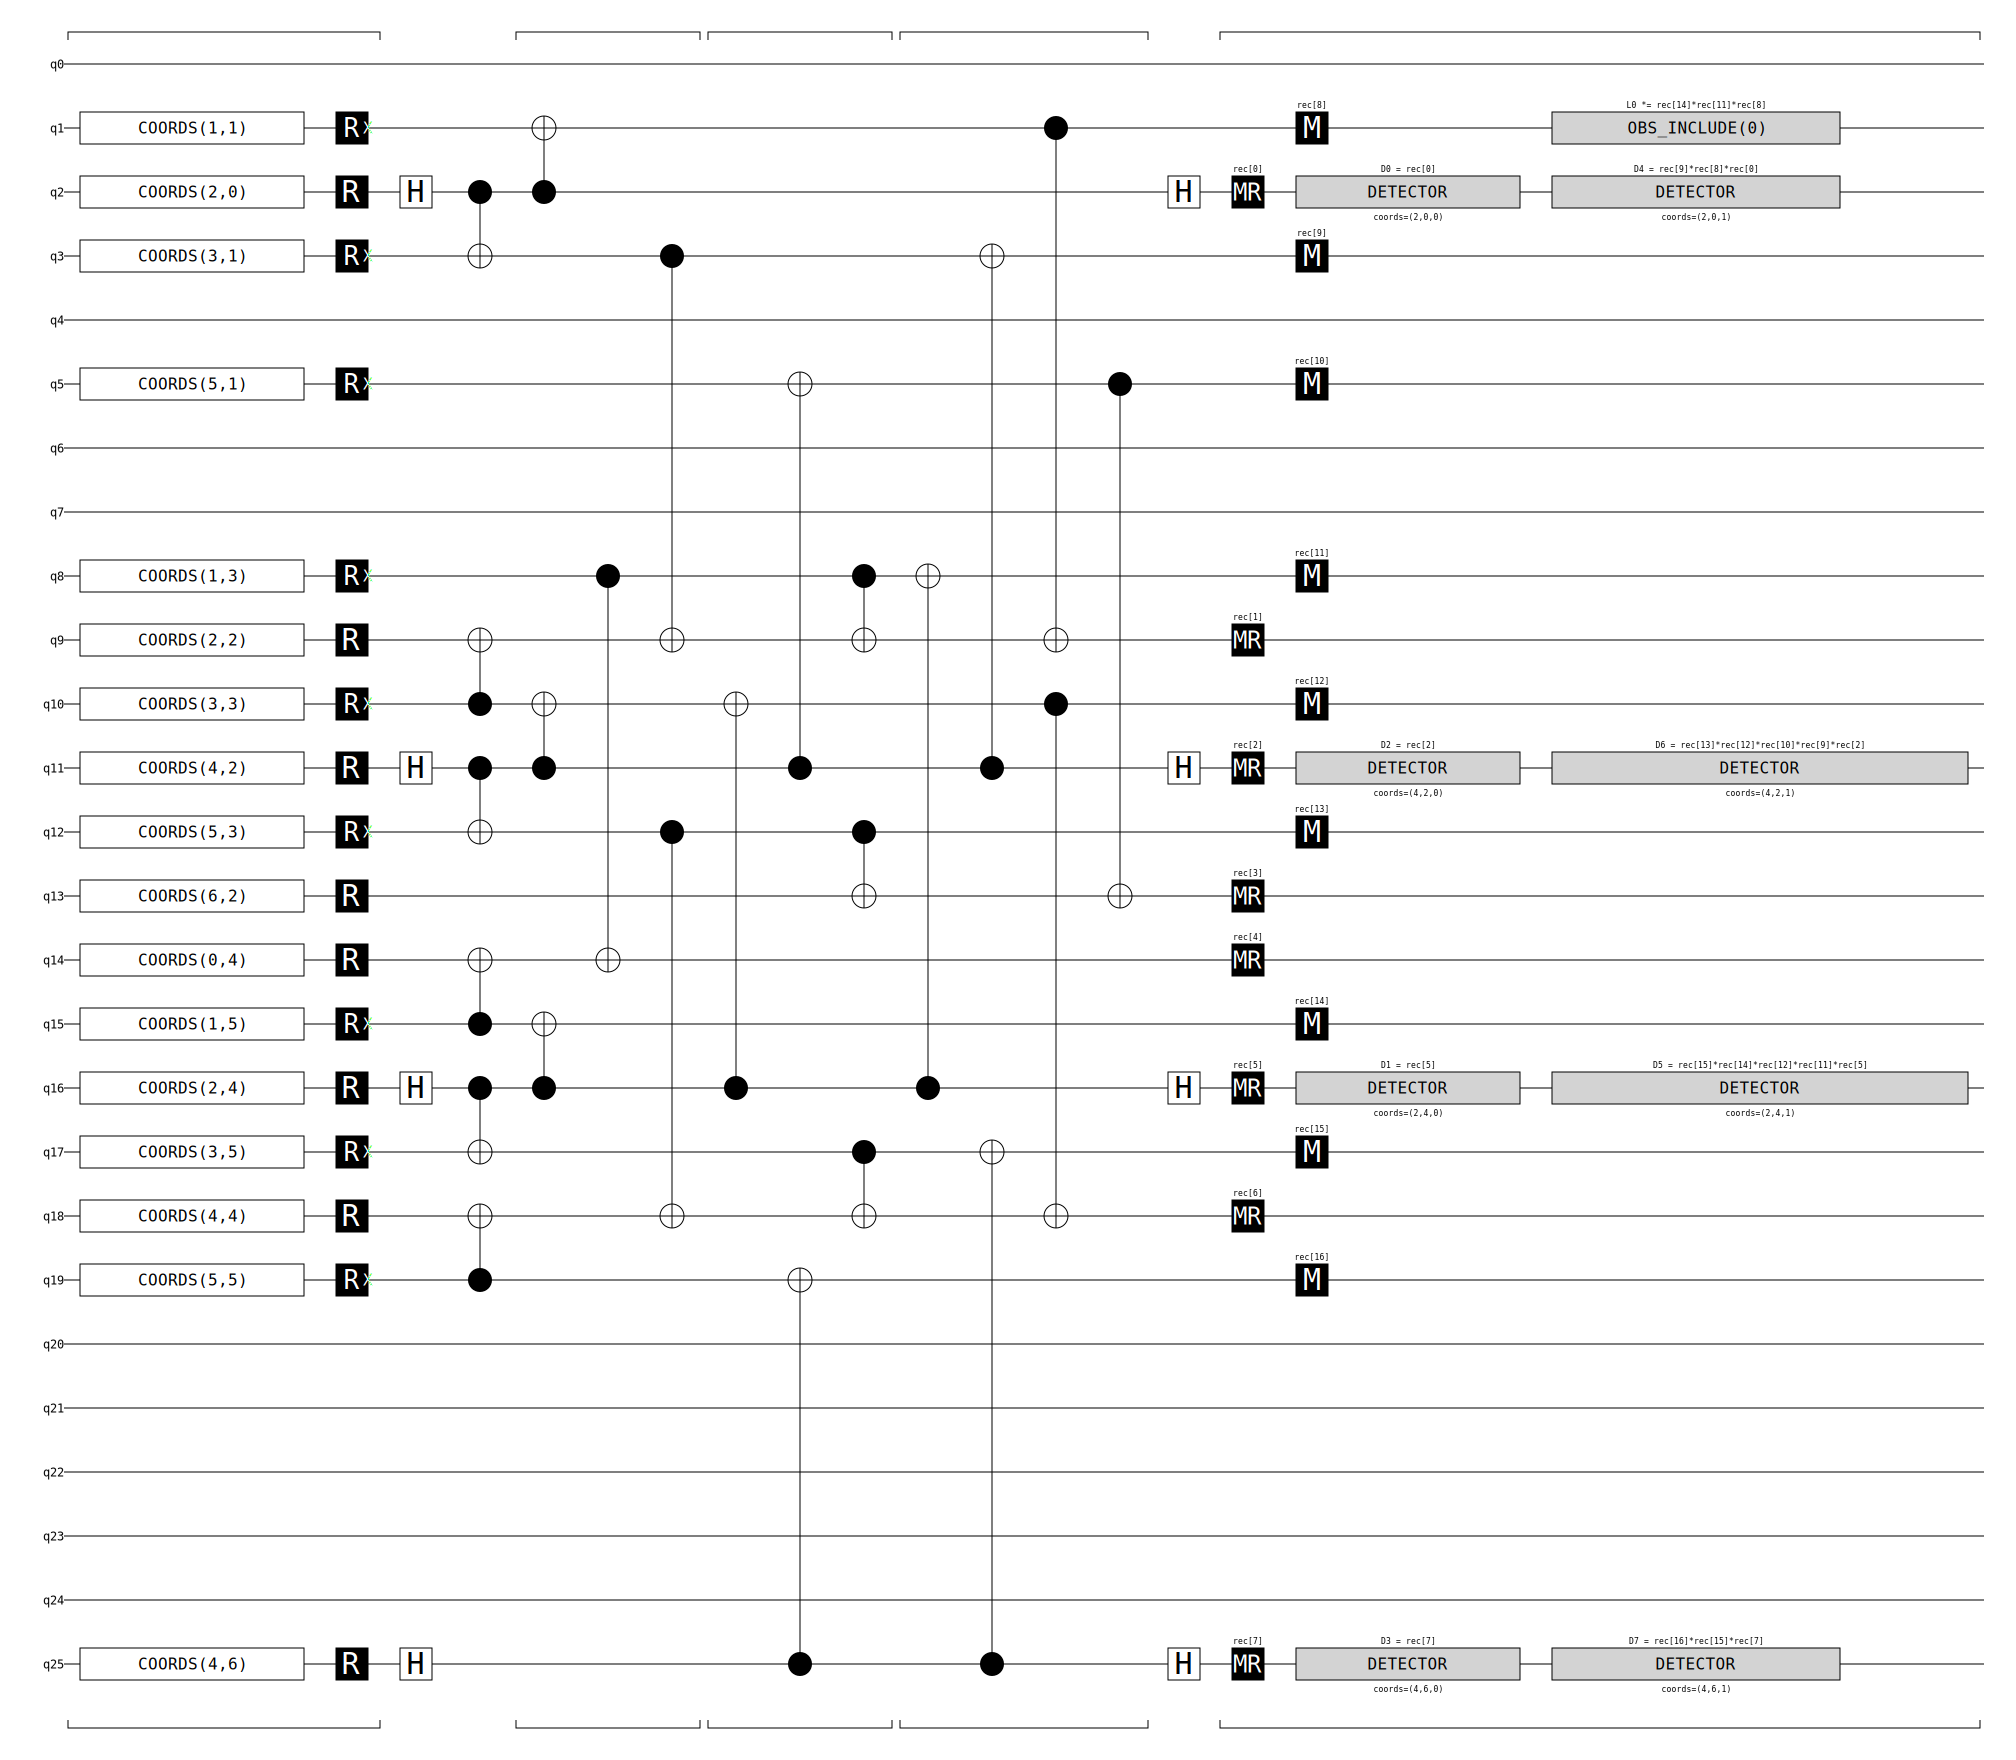

In [9]:
stim_circuit_x = gen_circuit(3, x_mem=True)
stim_circuit_x_text = str(stim_circuit_x)
stim_circuit_x_text = stim_circuit_x_text.replace("MX ", "M ")
# stim_circuit_x_text = stim_circuit_x_text.replace("MR ", "I ")

stim_circuit_x = stim.Circuit(stim_circuit_x_text)
stim_sampler = stim_circuit_x.compile_sampler()
num_shots = 1000000
stim_samples = stim_sampler.sample(num_shots)

stim_circuit_x.diagram('timeline-svg')

In [10]:
total_excitations = np.sum(stim_samples)
num_shots = stim_samples.shape[0]

expectation_value = total_excitations / num_shots

print(f"Expectation value of the excited state population: {expectation_value}")

Expectation value of the excited state population: 6.49954


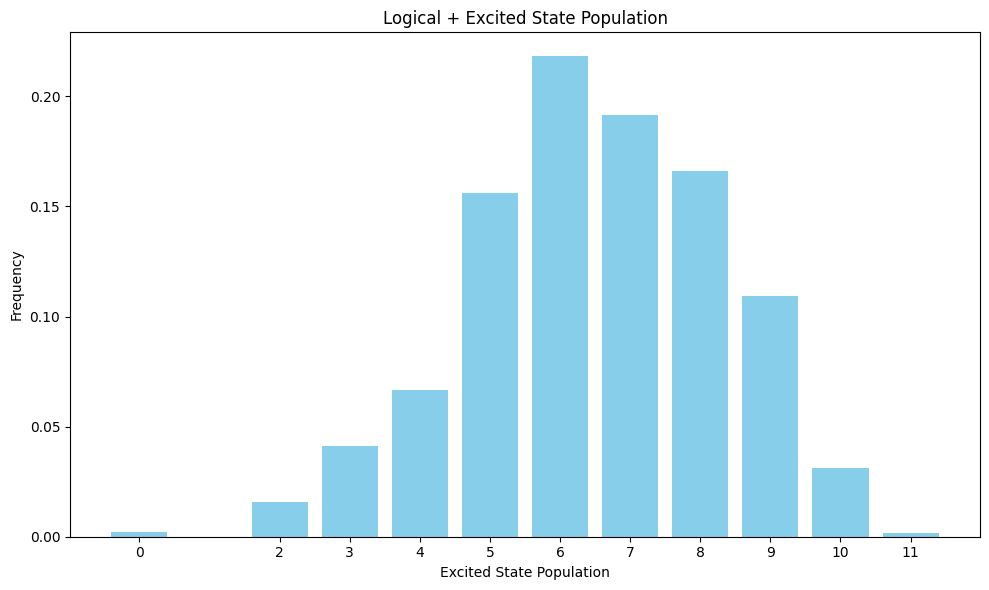

In [11]:
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter

# For each sample, count the number of excited states (1s).
excited_state_counts = [np.sum(row) for row in stim_samples]

# Count the occurrences of each excited state population count.
population_counts = Counter(excited_state_counts)

# Prepare data for plotting, ensuring it's sorted by the population count.
labels, counts = zip(*sorted(population_counts.items()))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, np.array(counts)/num_shots, color='skyblue')
plt.xlabel("Excited State Population")
plt.ylabel("Frequency")
plt.title(f"Logical + Excited State Population")
plt.xticks(labels) # Ensure all population counts are shown as ticks
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

# The variable stim_samples from the previous cell contains the measurement data.
# We calculate the total number of '1's across all shots and divide by the number of shots.
total_excitations = np.sum(stim_samples)
num_shots = stim_samples.shape[0]

expectation_value = total_excitations / num_shots

print(f"Expectation value of the excited state population: {expectation_value}")

Expectation value of the excited state population: 6.49954


In [13]:
distances = [3,5,7,11]
num_shots = 1000000

x_mem = []
one_mem = []
zero_mem = []

for d in distances:
    stim_circuit_x = gen_circuit(d, x_mem=True)
    stim_circuit_x_text = str(stim_circuit_x)
    # stim_circuit_x_text = stim_circuit_x_text.replace("MR ", "I ")
    stim_circuit_x = stim.Circuit(stim_circuit_x_text)
    stim_sampler = stim_circuit_x.compile_sampler()
    stim_samples = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples)
    num_shots = stim_samples.shape[0]
    expectation_value = total_excitations / num_shots
    x_mem.append(expectation_value/stim_circuit_x.num_qubits)


    stim_circuit_zero = gen_circuit(d)
    stim_circuit_zero_text = str(stim_circuit_zero)
    # stim_circuit_zero_text = stim_circuit_zero_text.replace("MR ", "I ")
    stim_circuit_zero_text = stim_circuit_zero_text.replace("M ", "MX ")
    stim_circuit_zero = stim.Circuit(stim_circuit_zero_text)
    stim_sampler = stim_circuit_zero.compile_sampler()
    stim_samples = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples)
    num_shots = stim_samples.shape[0]
    expectation_value = total_excitations / num_shots
    zero_mem.append(expectation_value/stim_circuit_zero.num_qubits)

    stim_circuit_one = gen_circuit(d, logical=True)
    stim_circuit_one_text = str(stim_circuit_one)
    # stim_circuit_one_text = stim_circuit_one_text.replace("MR ", "I ")
    stim_circuit_one_text = stim_circuit_one_text.replace("M ", "MX ")
    stim_circuit_one = stim.Circuit(stim_circuit_one_text)
    stim_sampler = stim_circuit_one.compile_sampler()
    stim_samples = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples)
    num_shots = stim_samples.shape[0]
    expectation_value = total_excitations / num_shots
    one_mem.append(expectation_value/stim_circuit_one.num_qubits)

# stim_circuit_x.diagram('timeline-svg')

In [14]:
print(zero_mem)
print(one_mem)
print(x_mem)

[np.float64(0.2499720769230769), np.float64(0.289031375), np.float64(0.3092904915254237), np.float64(0.33028391240875915)]
[np.float64(0.28852203846153845), np.float64(0.304622921875), np.float64(0.317777686440678), np.float64(0.3339209489051095)]
[np.float64(0.24989815384615385), np.float64(0.289033734375), np.float64(0.30932336440677966), np.float64(0.33025530656934304)]


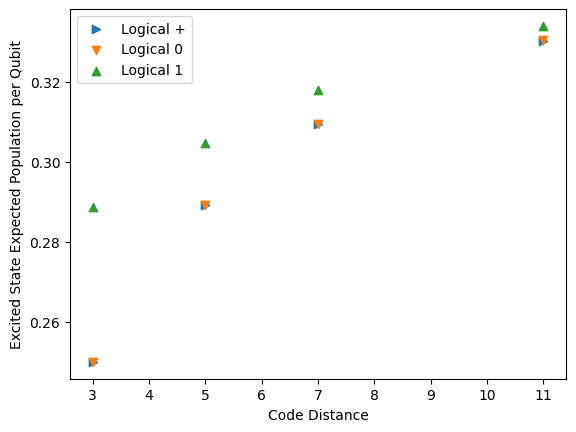

In [15]:
plt.scatter(distances, x_mem, marker='>', label='Logical +')
plt.scatter(distances, zero_mem, marker='v',label='Logical 0')
plt.scatter(distances, one_mem, marker='^',label='Logical 1')
plt.xlabel("Code Distance")
plt.ylabel("Excited State Expected Population per Qubit")
# plt.title("+ State Population vs. Code Distance")
plt.legend()
plt.show()

In [16]:
distances = [3,5,7,9,11]

num_shots = 1000000

x_mem = []
one_mem = []
zero_mem = []

for d in distances:
    stim_circuit_x = gen_circuit(d, x_mem=True)
    stim_circuit_x_text = str(stim_circuit_x)
    stim_circuit_x_text = stim_circuit_x_text.replace("MX ", "M ")
    # stim_circuit_x_text = stim_circuit_x_text.replace("MR ", "I ")
    stim_circuit_x = stim.Circuit(stim_circuit_x_text)
    
    stim_sampler = stim_circuit_x.compile_sampler()
    stim_samples = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples)
    num_shots = stim_samples.shape[0]
    expectation_value = total_excitations / num_shots
    x_mem.append(expectation_value/stim_circuit_x.num_qubits)


    stim_circuit_zero = gen_circuit(d)
    stim_circuit_zero_text = str(stim_circuit_zero)
    # stim_circuit_zero_text = stim_circuit_zero_text.replace("M ", "I ")
    # stim_circuit_zero_text = stim_circuit_zero_text.replace("M ", "MX ")
    stim_circuit_zero = stim.Circuit(stim_circuit_zero_text)
    stim_sampler = stim_circuit_zero.compile_sampler()
    stim_samples_zero = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples_zero)
    num_shots = stim_samples_zero.shape[0]
    expectation_value = total_excitations / num_shots
    zero_mem.append(expectation_value/stim_circuit_x.num_qubits)

    stim_circuit_one = gen_circuit(d, logical=True)
    stim_circuit_one_text = str(stim_circuit_one)
    # stim_circuit_one_text = stim_circuit_one_text.replace("M ", "I ")
    # stim_circuit_one_text = stim_circuit_one_text.replace("M ", "MX ")
    stim_circuit_one = stim.Circuit(stim_circuit_one_text)
    stim_sampler = stim_circuit_one.compile_sampler()
    stim_samples_one = stim_sampler.sample(num_shots)
    total_excitations = np.sum(stim_samples_one)
    num_shots = stim_samples_one.shape[0]
    expectation_value = total_excitations / num_shots
    one_mem.append(expectation_value/stim_circuit_x.num_qubits)

# stim_circuit_one.diagram('timeline-svg')

In [17]:
print(zero_mem)
print(one_mem)
print(x_mem)

[np.float64(0.24989461538461538), np.float64(0.289200625), np.float64(0.30933003389830505), np.float64(0.32183334574468087), np.float64(0.33029735766423357)]
[np.float64(0.2885183461538462), np.float64(0.30475790625), np.float64(0.31780850847457626), np.float64(0.32711027127659575), np.float64(0.3339077481751825)]
[np.float64(0.2500193076923077), np.float64(0.289099203125), np.float64(0.3093461355932204), np.float64(0.321776), np.float64(0.330295299270073)]


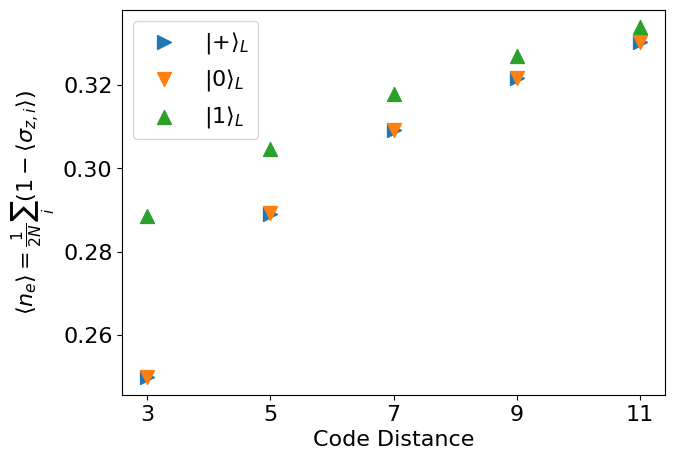

In [18]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7, 5))

plt.scatter(distances, x_mem, marker='>', s=100, label=r'$|\plus\rangle_L$')
plt.scatter(distances, zero_mem, marker='v', s=100, label=r'$|0\rangle_L$')
plt.scatter(distances, one_mem, marker='^', s=100, label=r'$|1\rangle_L$')
plt.xticks(distances)

plt.xlabel("Code Distance")
plt.ylabel(r'$\langle n_e \rangle = \frac{1}{2N}\sum_i (1 - \langle \sigma_{z,i} \rangle)$')
# plt.title("Excited State Population vs. Code Distance")
plt.legend()
plt.savefig(f'./figures/surface_code_exc.pdf', dpi=500, bbox_inches='tight')
# plt.show()